***Copyright 2020 Google LLC.***

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
import numpy as np
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt

In [0]:
tf.enable_v2_behavior()

In [0]:
# Mode as a function of observation
def f(s):
  return np.sin(s*2*np.pi/100.)/2.

In [0]:
N = 100
s = np.random.uniform(-100, 100, size=N)  # observations between -100 and 100
a = np.random.uniform(-1, 1, size=N)  # Actions between -1 and 1

In [0]:
P = 0.2
y = -100*np.abs(a - f(s))**P
y /= np.max(np.abs(y))
print(np.max(y))
print(np.min(y))

-0.19769162598050274
-1.0


[]

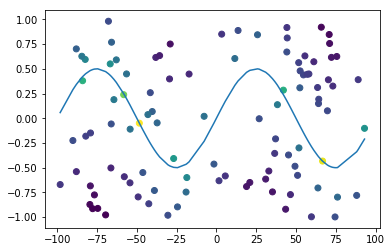

In [0]:
plt.scatter(s, a, c=y)
plt.plot(np.sort(s), f(np.sort(s)))
plt.plot()

# Explanation

Observations $s$ are scalar values between -100 and 100. Actions $a$ are scalar values between -1 and 1.

The plot above shows $(s, a)$ pairs, with their corresponding targets $y$ as color (dark is low, light is hight). The high target regions follow the curve $f$, which gives the mode (argmax action) as a function of $s$.

The goal is to recover $f$ from the given data points.


In [0]:
data = (s[:, np.newaxis], a[:, np.newaxis], y[:, np.newaxis])
s_features = tf.constant(np.linspace(-100, 100, 50)[np.newaxis, :], dtype=tf.float32)

hidden_widths = [1000, 500]
model = tf.keras.Sequential(
    [tf.keras.layers.Lambda(lambda x: tf.exp(-(x - s_features)**2/2000))]
    + [tf.keras.layers.Dense(w, activation='relu') for w in hidden_widths]
    + [tf.keras.layers.Dense(1, activation=None)]
)

What loss functions best recover the curve $f$ from our dataset?

In [0]:
# loss A
#    ||h(s) - a|^p - R|^q
# This is danabo's mode regression loss

p = 0.1
q = 1/P
# p = q = 2.0
def loss(model, s, a, y):
  reg = tf.linalg.global_norm(model.trainable_variables)
  return tf.reduce_mean(tf.abs(-tf.abs(model(s)-a)**p - y)**q) + 0.003*reg

In [0]:
# loss B
#    |h(s) - a|^p * exp(R/tau)
# This is one of Dale's surrogate loss, specifically dot-product loss.

p = 1.0
tau = 1/10.
def loss(model, s, a, y):
  reg = tf.linalg.global_norm(model.trainable_variables)
  target = tf.cast(tf.exp(y/tau), tf.float32)
  return tf.reduce_mean(tf.abs(model(s)-a)**p * target) + 0.0005*reg

In [0]:
np.var(s)

3297.3220206374854

In [0]:
# Initialize model

device_string = '/device:GPU:0'
# device_string = '/device:TPU:0'
# device_string = ''  # CPU

with tf.device(device_string):
  model(data[0])
  print(loss(model, *data).numpy())  # Initialize model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

0.014822608


In [0]:
def sample_batch(batch_size, *args):
  assert args
  idx = np.random.choice(args[0].shape[0], batch_size)
  return tuple([arg[idx] for arg in args])

In [0]:
for i in range(10000):
  # batch = sample_batch(100, *data)
  batch = data
  optimizer.minimize(lambda: loss(model, *batch), model.trainable_variables)
  if i % 100 == 0:
    print(i, '\t', loss(model, *data).numpy())

Test recovery of $f$.

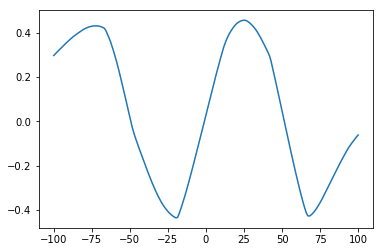

In [0]:
X = np.linspace(-100, 100, 200)[:, np.newaxis]
Y = model(X).numpy()
plt.plot(X, Y)
plt.show()